In [20]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [21]:
repo_list = pd.DataFrame()
repo_list_query = f"""
SELECT repo_id, repo_name, repo_path from repo
WHERE repo_name = 'concourse' OR repo_name = 'postfacto' or repo_name = 'clarity' or repo_name = 'gpdb' or
      repo_name = 'kpack' or repo_name = 'rabbitmq-server' or repo_name = 'sonobuoy' or repo_name = 'velero';
    """
repo_list = pd.read_sql_query(repo_list_query, con=engine)
print(repo_list)

    repo_id        repo_name                              repo_path
0     26235        concourse               github.com/pcfdev-forks/
1     28051        concourse                  github.com/concourse/
2     28030         sonobuoy               github.com/vmware-tanzu/
3     27913          clarity                     github.com/vmware/
4     26983        postfacto                    github.com/pivotal/
5     27169             gpdb                github.com/pivotal-gss/
6     25857             gpdb               github.com/greenplum-db/
7     28031           velero               github.com/vmware-tanzu/
8     25432  rabbitmq-server                   github.com/rabbitmq/
9     26600             gpdb  github.com/Pivotal-Field-Engineering/
10    27043            kpack                    github.com/pivotal/


In [22]:
## List of repository IDs for the report
#repo_dict = {25760, 25663} #spring-boot & spring-framework
#repo_dict = {28051} # concourse
#repo_dict = {26983} #postfacto
#repo_dict = {25432} #rabbitmq-server
#repo_dict = {25663} #spring-framework
#repo_dict = {28030} #sonobuoy
repo_dict = {28031} #velero
#repo_dict = {27913} #clarity

In [23]:
#from datetime import date
import datetime 

current = datetime.date.today()
today = "'" + str(current) + "'"
#print(today)

first_current = current.replace(day=1)
last_month = first_current - datetime.timedelta(days=1)
end_date = "'" + str(last_month) + "'"
print(end_date)

start = last_month - datetime.timedelta(days=365)
year_ago = "'" + str(start) + "'"
print(year_ago)

'2020-02-29'
'2019-03-01'


In [62]:
#Commit data - from humans excluding known bots
commitsDF = pd.DataFrame()
for value in repo_dict: 
    commitsquery = f"""
                    SELECT
                        DISTINCT(cmt_commit_hash),
                        CASE WHEN contributors.cntrb_canonical IS NOT NULL THEN contributors.cntrb_canonical ELSE cmt_author_email END AS cntrb_canonical,
                        CASE WHEN canonical_full_names.cntrb_full_name IS NOT NULL THEN canonical_full_names.cntrb_full_name ELSE cmt_author_name END AS canonical_full_name,
                        cmt_author_name, cmt_author_email, repo_id, cmt_author_timestamp 
                    FROM commits 
                        LEFT OUTER JOIN contributors ON cntrb_email = cmt_author_email
                        LEFT OUTER JOIN (
                            SELECT cntrb_canonical, cntrb_full_name 
                            FROM contributors
                            WHERE cntrb_canonical = cntrb_email
                        ) canonical_full_names
                        ON canonical_full_names.cntrb_canonical = contributors.cntrb_canonical
                    WHERE
                        repo_id = {value}
                        AND cmt_author_name NOT LIKE 'snyk%%'
                        AND cmt_author_name NOT LIKE '%%bot'
                        AND cmt_author_name != 'Spring Operator'
                        AND cmt_author_name != 'Spring Buildmaster'
                         AND cmt_author_timestamp >= {year_ago}
                         AND cmt_author_timestamp <= {end_date}
                    ORDER BY
                        cntrb_canonical;
                    """
    
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {value};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]
    
commitsDF = pd.read_sql_query(commitsquery, con=engine)
total_commits = commitsDF.cmt_commit_hash.nunique()                     

In [63]:
print(total_commits)
print(commitsDF)

675
                              cmt_commit_hash  \
0    81a4fcbb24095f45eccf6460540e24c76d332f1d   
1    ca6c0a5a3d1718e1b2f7f4e133b611c2a7dd2e88   
2    87be77513963351072562c802decb56364a489dc   
3    1a1372550d7ab12bc1f9a5fe5ccb4f09d2a4969d   
4    5a811b46294acdf65b4f919d93213d0b035d801d   
..                                        ...   
670  f829dabcf4469685343a97ec51042d8a641b58bb   
671  89ca2571f3c175526b5c982fd2cd177718349be0   
672  662a36df904996d96a4a129d864ca8b37337d71b   
673  4beb8aab3cfaf1efa026dc6d8a2e72b96c64325f   
674  e74923aea6c5b2b6b69b7ed79002c783655ce2b6   

                               cntrb_canonical          canonical_full_name  \
0    32073428+spiffcs@users.noreply.github.com  Christopher Angelo Phillips   
1    32073428+spiffcs@users.noreply.github.com  Christopher Angelo Phillips   
2     32709700+cognoz@users.noreply.github.com               Roman Klimenko   
3     33252549+mynktl@users.noreply.github.com                       Mayank   
4     332525

In [49]:
authorDF = pd.DataFrame()
authorDF = commitsDF.canonical_full_name.value_counts()
authorDF = authorDF.reset_index()
authorDF.columns = ['name', 'commits']
authorDF['percent'] = authorDF['commits'] / total_commits
print(authorDF.head(50))

                           name  commits   percent
0                   Steve Kriss     6321  9.364444
1                      Carlisia      993  1.471111
2                  Lee Springer      840  1.244444
3            Adnan Abdulhussein      512  0.758519
4                Nolan Brubaker      277  0.410370
5                 Jonas Rosland      100  0.148148
6               Ashish Amarnath       58  0.085926
7               Guilhem Lettron       36  0.053333
8                  jonasrosland       33  0.048889
9                Cyrill Troxler       28  0.041481
10                  Steve Chung       24  0.035556
11                       jhsiao       19  0.028148
12               Anshul Chandra       18  0.026667
13           Fábio Franco Uechi       13  0.019259
14                Antony S Bett       12  0.017778
15                Prajyot-Parab       12  0.017778
16                  John Naulty       11  0.016296
17                     carthewd       11  0.016296
18                  Joshua Wong

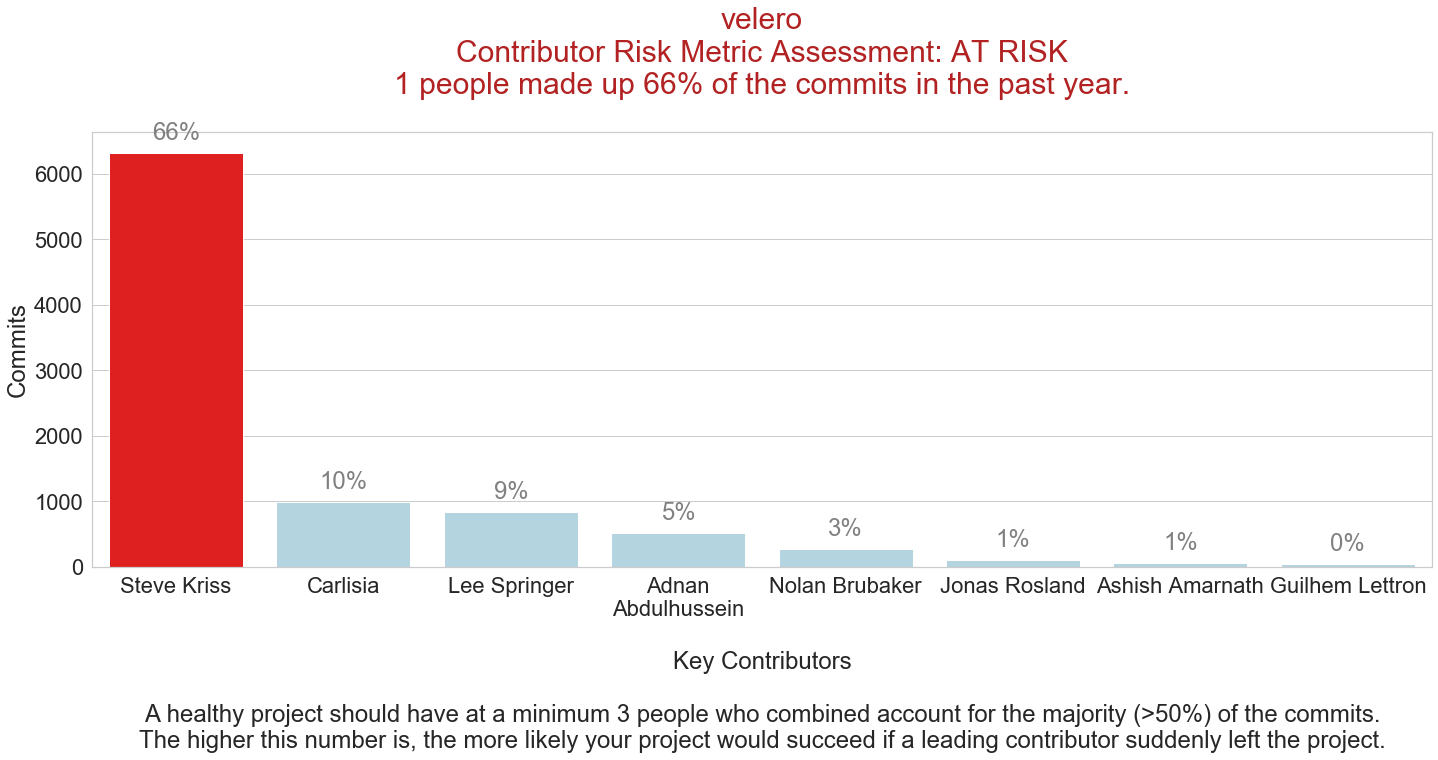

In [27]:
import textwrap

cum_percent = 0
people_list = []

i = 1
num_people = 0

for item in authorDF.iterrows():
    name = item[1]['name']
    percent = item[1]['percent']
    commits = item[1]['commits']
    
    cum_percent += percent
    
    people_list.append([name, percent, commits])
    
    if (cum_percent > .50 and num_people == 0):
        num_people = i
        risk_percent = cum_percent
        
    if i == 8:
        break
    i+=1
    
risk_list = []
bar_colors = []

j = 1
for person in people_list:
    name = person[0]
    if len(name) > 15:
        new_name = textwrap.wrap(name, 15)
        name = '\n'.join(new_name)
    percent = person[1]
    commits = person[2]
    risk_list.append([name, percent, commits])
    
    if (num_people < 3 and j <= num_people):
        bar_colors.append('red')
    else:
        bar_colors.append('lightblue')
    
    j+=1
    

names = [item[0] for item in risk_list]
percents = [item[1] for item in risk_list]
commits = [item[2] for item in risk_list]

sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()

# the size of A4 paper
fig.set_size_inches(24, 8)

title = repo_name + "\nContributor Risk Metric Assessment: "

if num_people < 3:
    title += "AT RISK"
    title_color = 'firebrick'
else:
    title += "Healthy"
    title_color = 'forestgreen'
title += "\n" + str(num_people) + " people made up " + "{:.0%}".format(risk_percent) + " of the commits in the past year.\n"

risk_bar = sns.barplot(x=names, y=commits, palette=bar_colors).set_title(title, fontsize=30, color=title_color)

risk_bar_labels = ax.set_xticklabels(names, wrap=True)
risk_bar_labels = ax.set_ylabel('Commits')
risk_bar_labels = ax.set_xlabel('\nKey Contributors\n\nA healthy project should have at a minimum 3 people who combined account for the majority (>50%) of the commits.\nThe higher this number is, the more likely your project would succeed if a leading contributor suddenly left the project.')

i = 0
for p in ax.patches:
    ax.annotate("{:.0%}".format(percents[i]), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', color='gray', xytext=(0, 20),
        textcoords='offset points')
    i+=1

![title](output/velero_contrib_risk.png)

In [16]:
#Commit data - from humans excluding known bots
commitsDF = pd.DataFrame()
for value in repo_dict: 
    commitsquery = f"""
                    SELECT
                        CASE WHEN contributors.cntrb_canonical IS NOT NULL THEN contributors.cntrb_canonical ELSE cmt_author_email END AS cntrb_canonical,
                        CASE WHEN canonical_full_names.cntrb_full_name IS NOT NULL THEN canonical_full_names.cntrb_full_name ELSE cmt_author_name END AS canonical_full_name,
                        cmt_author_name, cmt_author_email, repo_id, cmt_id, cmt_author_timestamp 
                    FROM commits 
                        LEFT OUTER JOIN contributors ON cntrb_email = cmt_author_email
                        LEFT OUTER JOIN (
                            SELECT cntrb_canonical, cntrb_full_name 
                            FROM contributors
                            WHERE cntrb_canonical = cntrb_email
                        ) canonical_full_names
                        ON canonical_full_names.cntrb_canonical = contributors.cntrb_canonical
                    WHERE
                        repo_id = {value}
                        AND cmt_author_name NOT LIKE 'snyk%%'
                        AND cmt_author_name NOT LIKE '%%bot'
                        AND cmt_author_name != 'Spring Operator'
                        AND cmt_author_name != 'Spring Buildmaster'
                         AND cmt_author_timestamp >= {year_ago}
                         AND cmt_author_timestamp <= {end_date}
                    ORDER BY
                        cmt_id;
                    """
    
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {value};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]
    
commitsDF = pd.read_sql_query(commitsquery, con=engine)
total_commits = commitsDF.cmt_id.nunique()                     

In [17]:
print(commitsDF)

          cntrb_canonical canonical_full_name cmt_author_name  \
0       krisss@vmware.com         Steve Kriss     Steve Kriss   
1       krisss@vmware.com         Steve Kriss     Steve Kriss   
2       krisss@vmware.com         Steve Kriss     Steve Kriss   
3       krisss@vmware.com         Steve Kriss     Steve Kriss   
4       krisss@vmware.com         Steve Kriss     Steve Kriss   
...                   ...                 ...             ...   
9541  jrosland@vmware.com        jonasrosland    jonasrosland   
9542  jrosland@vmware.com        jonasrosland    jonasrosland   
9543  jrosland@vmware.com        jonasrosland    jonasrosland   
9544  jrosland@vmware.com        jonasrosland    jonasrosland   
9545  jrosland@vmware.com        jonasrosland    jonasrosland   

         cmt_author_email  repo_id    cmt_id      cmt_author_timestamp  
0       krisss@vmware.com    28031  40874332 2019-04-12 19:14:17+00:00  
1       krisss@vmware.com    28031  40874334 2019-03-27 22:54:04+00:00  
